**My best model is [CNN](https://colab.research.google.com/drive/1QyOq61hVrh6lIZUm60JfhruL55nSTZhO#scrollTo=05k8oOX76U5z) model. But I tried two other models and evaluate their performances. All of them are exist in this notebook.**



---





#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

#Data preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [ ]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [ ]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (tf.convert_to_tensor(Y1_cat[num1]),tf.convert_to_tensor(Y2_cat[num2]))

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [ ]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: bird, second = ship


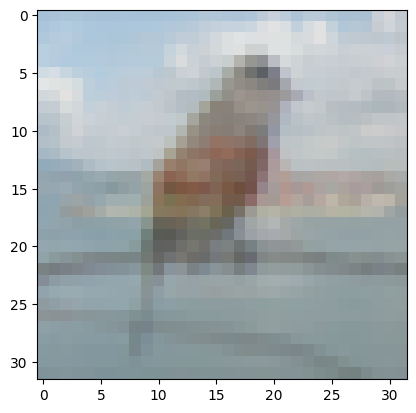

In [ ]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [ ]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [ ]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [ ]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [ ]:
eval_model(random_model)

0.2012

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.19976
standard deviation =  0.0024414954433707205


#Config

Here I select the validation data by randomly choosing 20% of the training dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Training the model
batch_size = 512
steps_per_epoch = 500
epochs = 100

train_val_split = 0.2


indices = np.arange(cifar10_x_train_1.shape[0])
train_1_idx, val_1_idx = train_test_split(indices, test_size=train_val_split, random_state=42)
train_2_idx, val_2_idx = train_test_split(indices, test_size=train_val_split, random_state=42)


traingen = datagenerator(cifar10_x_train_1[train_1_idx],cifar10_x_train_2[train_2_idx],cifar10_y_train_1[train_1_idx],cifar10_y_train_2[train_2_idx],batch_size)
valgen = datagenerator(cifar10_x_train_1[val_1_idx],cifar10_x_train_2[val_2_idx],cifar10_y_train_1[val_1_idx],cifar10_y_train_2[val_2_idx],batch_size)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 100)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='model.keras',
    save_best_only = True,
    mode = 'auto',
    verbose = 1
)

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation results
def plot_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_acc_1 = history.history['output_1_accuracy']
    train_acc_2 = history.history['output_2_accuracy']

    val_acc_1 = history.history['val_output_1_accuracy']
    val_acc_2 = history.history['val_output_2_accuracy']
    epochs_range = range(len(loss))

    plt.figure(figsize=(20, 6))

    # # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_acc_1, label='output 1')
    plt.plot(epochs_range, train_acc_2, label='output 2')
    plt.title('Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, val_acc_1, label='output 1')
    plt.plot(epochs_range, val_acc_2, label='output 2')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [ ]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  predictions = model.predict(eval_samples_x)

  correct_guesses_1 = np.argmax(predictions[0],axis=1) == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = np.argmax(predictions[1],axis=1) == np.argmax(eval_samples_y[1],axis=1)

  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

def get_svd_mean(model):
    repeat_eval = 10
    eval_results = []
    for i in range(repeat_eval):
      eval_results.append(eval_model(model))

    print("mean accuracy = ", np.mean(eval_results))
    print("standard deviation = ", np.std(eval_results))

# CNN (The Best Model)

This is a CNN model consist of a 3 blocks, in which each block consist of 2 Conv2D and 2 BatchNormalization after wach of them with a MaxPooling and a Dropout. This model consist of the 1,151,562 parameters in total.

In [ ]:
def cifar10_model():
    input_layer = Input(shape=(32, 32, 3))

    # Convolutional block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolutional block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolutional block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Output branches for the two predictions
    output_1 = Dense(5, activation='softmax', name='output_1')(x)
    output_2 = Dense(5, activation='softmax', name='output_2')(x)

    model = Model(inputs=input_layer, outputs=[output_1, output_2])
    return model

In [ ]:
# Instantiate the model
model = cifar10_model()
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy', 'accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 128)      │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 8, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 256)      │        590,080 │ batch_normalization_4… │
├──────────────────────

 Total params: 1,151,562 (4.39 MB)

 Trainable params: 1,149,770 (4.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
history = model.fit(
    traingen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valgen,
    validation_steps=100,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.3727 - output_1_accuracy: 0.4770 - output_1_loss: 1.2702 - output_2_accuracy: 0.5620 - output_2_loss: 1.1026
Epoch 1: val_loss improved from inf to 3.27819, saving model to model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 2.3708 - output_1_accuracy: 0.4774 - output_1_loss: 1.2694 - output_2_accuracy: 0.5625 - output_2_loss: 1.1015 - val_loss: 3.2782 - val_output_1_accuracy: 0.3898 - val_output_1_loss: 1.6765 - val_output_2_accuracy: 0.4786 - val_output_2_loss: 1.6017 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009772372209558107.
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6366 - output_1_accuracy: 0.6330 - output_1_loss: 0.9345 - output_2_accuracy: 0.7391 - output_2_loss: 0.7021
Epoch 2: val_loss improved from 3.27819 to 1.85563, saving model to model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Load the model with best performance
model = load_model('model.keras')
eval_model(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


0.8113

In [ ]:
get_svd_mean(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
mean accuracy =  0.8154199999999999
standard deviation =  0.0032385336187848927


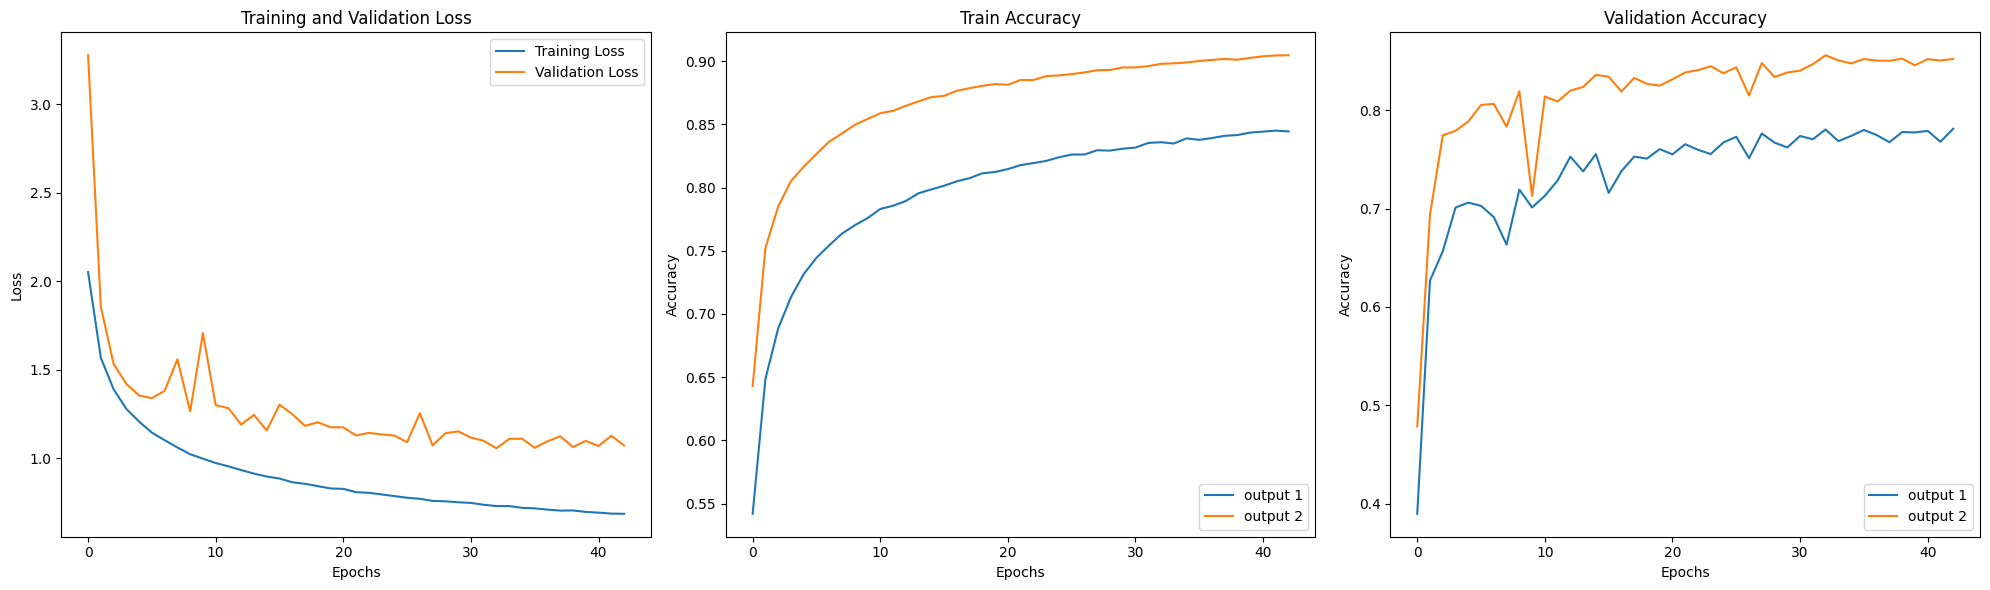

In [ ]:
# Assuming `history` is the returned object from model.fit
plot_results(history)

Here in our plots we can see that the Training Loss decrease and the Validation Loss also decrease with some fluctuation.

#UNet

**UNet Structure**

U-Net is a convolutional neural network that was developed for biomedical image segmentation. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.
The network architecture consist two main part:
1. the left side of the U, called the contracting path, is characterized by convolutional layers together with max pooling operations for down-sampling
2. the right side of the U, called the expansive path, applies transposed convolution (in order to up-sample) and common convolutions

Each layer in the U-Net consists of 2 consecutive Convolution-Batch Normalization-Relu blocks (though original U-Net did not include batch normalization).

<br/><br/>
<img src=https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png alt="drawing" width="600"/>
<br/><br/>

**UNet in our model**

The CNN model in the previous section performs relatively good. Now we investigate the idea of having a UNet to transform the input data to two seperate images and pass these images to the CNN in the previous stage to classify them.

The hypothesis is that we expect the UNet to output two images that are well preseneted (let's say we expect each output to be one of the input images that is mixed with another one) for CNN to classify.
This model consist of 4,231,952 parameters in total.

In [ ]:
def classifier1(input_tensor):
    # Convolutional block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolutional block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolutional block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Output branches for the two predictions
    output = Dense(5, activation='softmax', name='output_1')(x)

    return output

def classifier2(input_tensor):
    # Convolutional block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolutional block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Convolutional block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Output branches for the two predictions
    output = Dense(5, activation='softmax', name='output_2')(x)

    return output

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2DTranspose

def conv_block(input_tensor, num_filters):
    # Convolutional block with two Conv2D layers followed by BatchNorm and ReLU.
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    # Encoder block with a convolutional block followed by MaxPooling2D.
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2), padding="same")(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    # Decoder block with a Conv2DTranspose layer for upsampling, concatenation with the encoder feature map, and a conv block.
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(32, 32, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    # Bridge
    b1 = conv_block(p3, 256)

    # Decoder
    d1 = decoder_block(b1, s3, 128)
    d2 = decoder_block(d1, s2, 64)
    d3 = decoder_block(d2, s1, 32)

    # Output layer
    # Classifying the first 32x32x3 output using the samme CNN in previous step
    output1 = Conv2D(3, (1, 1), activation="relu")(d3)
    output1 = classifier1(output1)

    # Classifying the second 32x32x3 output using the samme CNN in previous step
    output2 = layers.Conv2D(3, (1, 1), activation="relu")(d3)
    output2 = classifier2(output2)

    outputs = [output1, output2]

    # Build model
    model = Model(inputs, outputs)
    return model

In [ ]:
# Instantiate the model
model = build_unet(input_shape=(32, 32, 3))
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy', 'accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_153 (Conv2D)       │ (None, 32, 32, 32)     │            896 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_142   │ (None, 32, 32, 32)     │            128 │ conv2d_153[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_68             │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_154 (Conv2D)       │ (None, 32, 32, 32)     │          9,248 │ activation_68[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_143   │ (None, 32, 32, 32)     │            128 │ conv2d_154[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_69             │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 16, 16, 32)     │              0 │ activation_69[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_155 (Conv2D)       │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_144   │ (None, 16, 16, 64)     │            256 │ conv2d_155[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_70             │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_156 (Conv2D)       │ (None, 16, 16, 64)     │         36,928 │ activation_70[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_145   │ (None, 16, 16, 64)     │            256 │ conv2d_156[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_71             │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30     

 Total params: 4,231,952 (16.14 MB)

 Trainable params: 4,225,552 (16.12 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
history = model.fit(
    traingen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valgen,
    validation_steps=100,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.6119 - output_1_accuracy: 0.4270 - output_1_loss: 1.3615 - output_2_accuracy: 0.4851 - output_2_loss: 1.2503
Epoch 1: val_loss improved from inf to 2.47173, saving model to model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 44ms/step - loss: 2.6113 - output_1_accuracy: 0.4271 - output_1_loss: 1.3613 - output_2_accuracy: 0.4853 - output_2_loss: 1.2499 - val_loss: 2.4717 - val_output_1_accuracy: 0.4535 - val_output_1_loss: 1.4032 - val_output_2_accuracy: 0.5938 - val_output_2_loss: 1.0685 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009772372209558107.
Epoch 2/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.8801 - output_1_accuracy: 0.5708 - output_1_loss: 1.0716 - output_2_accuracy: 0.6964 - output_2_loss: 0.8085
Epoch 2: val_loss improved from 2.47173 to 2.04626, saving model to model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Load the model with best performance
model = load_model('model.keras')
eval_model(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


0.767

In [ ]:
get_svd_mean(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
mean accuracy =  0.7624
standard deviation =  0.001929248558377087


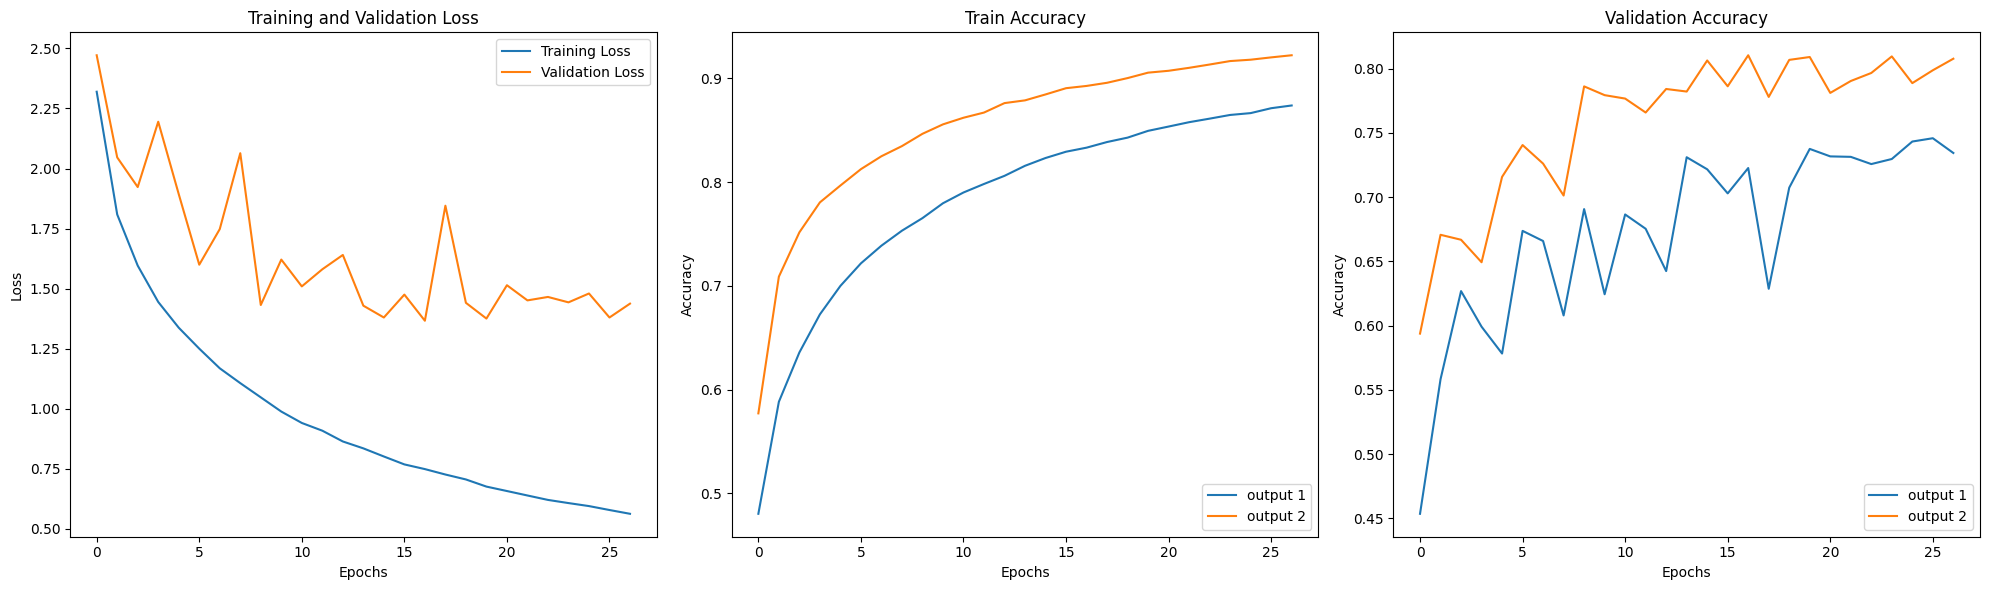

In [ ]:
# Assuming `history` is the returned object from model.fit
plot_results(history)

The plots indicate consistent training progress, with the loss (left) steadily decreasing for both training and validation. However, validation loss shows mild fluctuations, suggesting some instability.

#Residual UNet

The ***Deep Residual U-Net*** applies this architecture with one notable differences; a residual connection is introduced for each layer. This adds the input to each layer to the output of the same layer.

<br/><br/>
<img src="https://miro.medium.com/max/1356/1*N5FPYoOt6OhC-xTGO5chFQ.png" alt="drawing" width="400px;"/>
<br/><br/>

The approach is to add a shortcut or a *skip connection* that allows information to flow, well just say, more easily from one layer to the next’s next layer, i.e., you bypass data along with normal CNN flow from one layer to the next layer after the immediate next. This model consist of the 4,365,136 parameters in total. Here we can see a residual block:


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# First residual block does not contain a batch normalization and activation
def ResConvInit(feature_size, kernel_size, strides, input):

    x = Conv2D(feature_size, kernel_size, strides=strides, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(feature_size, kernel_size, strides=1, padding='same')(x)

    r = Conv2D(feature_size, 1, strides=1, padding='same')(input)
    r = BatchNormalization()(r)

    output = Add()([x, r])
    return output

def ResConv(feature_size, kernel_size, strides, input):

    x = BatchNormalization()(input)
    x = Activation('relu')(x)

    x = Conv2D(feature_size, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(feature_size, kernel_size, strides=1, padding='same')(x)

    r = Conv2D(feature_size, 1, strides=strides, padding='same')(input)
    r = BatchNormalization()(r)

    output = Add()([x, r])
    return output


def build_resunet(input_shape=(1000,1000,3)):

    input = Input(shape=input_shape)

    # encoder
    conv1 = ResConvInit(feature_size=32, kernel_size=3, strides=1, input=input)
    conv2 = ResConv(feature_size=64, kernel_size=3, strides=2, input=conv1)
    conv3 = ResConv(feature_size=128, kernel_size=3, strides=2, input=conv2)

    # bottleneck
    conv4 = ResConv(feature_size=256, kernel_size=3, strides=2, input=conv3)

    # decoder
    conv5 = UpSampling2D()(conv4)
    conv5 = concatenate([conv5, conv3], axis=3)
    conv5 = ResConv(128, 3, strides=1, input=conv5)

    conv6 = UpSampling2D()(conv5)
    conv6 = concatenate([conv6, conv2], axis=3)
    conv6 = ResConv(64, 3, strides=1, input=conv6)

    conv7 = UpSampling2D()(conv6)
    conv7 = concatenate([conv7, conv1], axis=3)
    conv7 = ResConv(32, 3, strides=1, input=conv7)

    output1 = layers.Conv2D(3, (1, 1), activation="relu")(conv7)
    output1 = classifier1(output1)
    output2 = layers.Conv2D(3, (1, 1), activation="relu")(conv7)
    output2 = classifier2(output2)

    outputs = [output1, output2]

    resunet = Model(input, outputs)

    return resunet


In [ ]:
model = build_resunet((32,32,3))
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy', 'accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_251 (Conv2D)       │ (None, 32, 32, 32)     │            896 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_232   │ (None, 32, 32, 32)     │            128 │ conv2d_251[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_108            │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_253 (Conv2D)       │ (None, 32, 32, 32)     │            128 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_252 (Conv2D)       │ (None, 32, 32, 32)     │          9,248 │ activation_108[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_233   │ (None, 32, 32, 32)     │            128 │ conv2d_253[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_28 (Add)              │ (None, 32, 32, 32)     │              0 │ conv2d_252[0][0],      │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_234   │ (None, 32, 32, 32)     │            128 │ add_28[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_109            │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_254 (Conv2D)       │ (None, 16, 16, 64)     │         18,496 │ activation_109[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_235   │ (None, 16, 16, 64)     │            256 │ conv2d_254[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_110            │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_256 (Conv2D)       │ (None, 16, 16, 64)     │          2,112 │ add_28[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_255 (Conv2D)       │ (None, 16, 16, 64)     │         36,928 │ activation_110[0][0]   │
├──────────────────────

 Total params: 4,365,136 (16.65 MB)

 Trainable params: 4,356,944 (16.62 MB)

 Non-trainable params: 8,192 (32.00 KB)

In [ ]:
history = model.fit(
    traingen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valgen,
    validation_steps=100,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.6738 - output_1_accuracy: 0.4087 - output_1_loss: 1.4012 - output_2_accuracy: 0.4862 - output_2_loss: 1.2726
Epoch 1: val_loss improved from inf to 3.05818, saving model to model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 2.6726 - output_1_accuracy: 0.4089 - output_1_loss: 1.4007 - output_2_accuracy: 0.4865 - output_2_loss: 1.2719 - val_loss: 3.0582 - val_output_1_accuracy: 0.3922 - val_output_1_loss: 1.6743 - val_output_2_accuracy: 0.5366 - val_output_2_loss: 1.3839 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009772372209558107.
Epoch 2/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9574 - output_1_accuracy: 0.5526 - output_1_loss: 1.1061 - output_2_accuracy: 0.6768 - output_2_loss: 0.8513
Epoch 2: val_loss improved from 3.05818 to 2.35409, saving model to model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Load the model with best performance
model = load_model('model.keras')
eval_model(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


0.7396499999999999

In [ ]:
get_svd_mean(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
mean accuracy =  0.74244
standard deviation =  0.003259432465936362


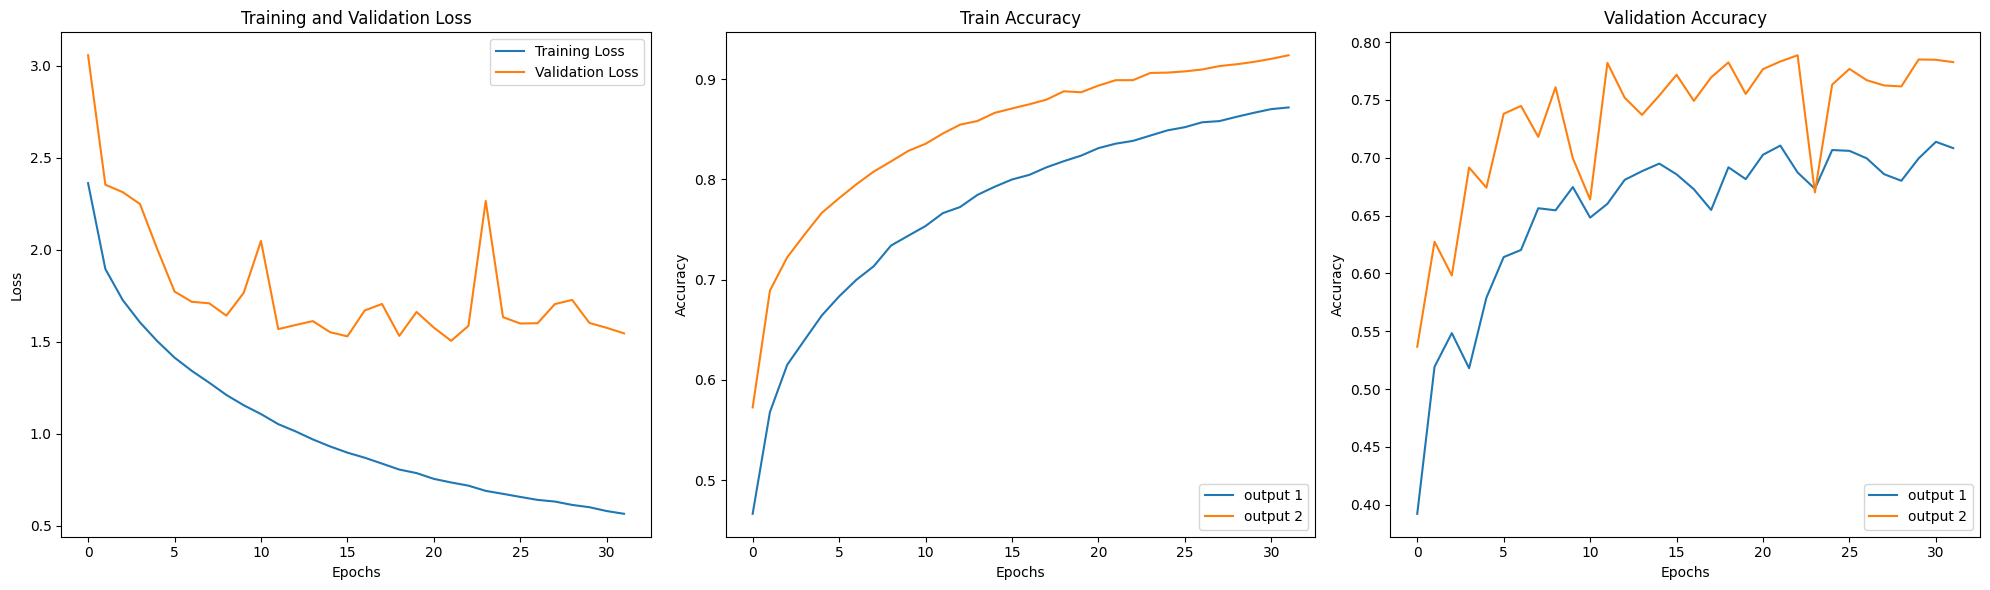

In [ ]:
# Assuming `history` is the returned object from model.fit
plot_results(history)

For both training and validation datasets, with the validation loss experiencing some fluctuations, while the accuracy increased.

#Choosing Model Parameters
In the project we try many possible parameters for the model as follow:


*   **Batchsize**: we test the from 64 to 1024 for the training and validation data an we saw that at first it improved until it reached 512 and then it reduced the performance. So, we choose 512 for the Batchsize of the CNN model, but in UNet and ResidualUNet we saw that the highest Batchsize just improve the accuracu around 1% but they made model to be overfit, so we choose 256 for the UNet and 128 for the ResidualUNet.
*   **Epoch**: At the first observation it is around 20, but we increased it according to our plots to avoid being overfit. Put epoch to 100 but non of the models reached that epoch because of earlystopping, they run until the half of it(50 epochs).
*   For the other parameter we just try the many values and select the best one.





Note:

I select the validation data by randomly choosing 20% of the training dataset as you can see in the [config](https://colab.research.google.com/drive/1QyOq61hVrh6lIZUm60JfhruL55nSTZhO#scrollTo=auy2g3PJ9NFt) section.



#Conclusion
َAt the end of the each block of the model there is a plot of the training and validation Loss and their accuracy during trainin. In all models the validation and training loss are decreased while the validation loss experience more fluctuatuion in the UNet and ResidualUNet models.

We can see all of the evaluation metric for these 3 models after running for 10 times as below:

|     **Model**     | **Mean Accuracy** | **Standard Deviation** |
|:-----------------:|:------------:|:----------------------:|
|      **CNN**      |     0.81     |          0.003         |
|      **UNet**     |     0.76     |          0.001         |
| **Residual UNet** |     0.74     |          0.003         |

As we can we can see that the **CNN** works better than the others. Also the UNet and ResidualUNet are the powerful models and have more parameter here, but as we can see a simpler CNN works better, It may because of that the CNN model is a simpler one so it can perform better in this project.

**All in all, CNN model with 0.81 accuracy and 0.003 STD is the my final model for this project.**



--THe END--


# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

